In [24]:
import numpy as np
import pandas as pd

def create_train_test(ratings, test_size=0.2, min_ratings=10, seed=42):
    np.random.seed(seed)
    test_set = np.zeros(ratings.shape)
    train_set = ratings.copy()

    for i in range(ratings.shape[0]):
        rated_indices = np.where(ratings[i, :] > 0)[0]
        if len(rated_indices) >= min_ratings:
            test_ratings = np.random.choice(rated_indices, size=int(len(rated_indices) * test_size), replace=False)
            train_set[i, test_ratings] = 0
            test_set[i, test_ratings] = ratings[i, test_ratings]

    return train_set, test_set


In [52]:
df = pd.read_csv('Users-Movies Matrix.csv', index_col='User_ID')

In [53]:
df = df.head(200)

In [54]:
ratings = df.values

# Split the data into training and test sets
train_ratings, test_ratings = create_train_test(ratings)

In [55]:
def matrix_factorization(R, P, Q, k=5, steps=150, alpha=0.01, beta=0.02, threshold=0.001):
    Q = Q.T # Transposes the item-feature matrix Q for easier matrix multiplication with P.
    prev_e = float('inf') # Initializes prev_e to infinity, which will be used to track the change in the error for early stopping.
    for step in range(steps): # Begins a loop that will run for a number of iterations specified by steps.
        for i in range(len(R)): 
            for j in range(len(R[i])): # These nested loops iterate over each element in the rating matrix R.
                if R[i][j] > 0: # Checks if the current rating is greater than 0 (indicating an actual rating, as opposed to a missing rating).
                    eij = R[i][j] - np.dot(P[i, :], Q[:, j]) # Calculates the error (eij) for the current rating by subtracting the predicted rating (obtained by the dot product of the user's and item's latent feature vectors) from the actual rating.
                    for r in range(k): # Iterates over each latent feature.
                        P[i][r] += alpha * (2 * eij * Q[r][j] - beta * P[i][r])
                        Q[r][j] += alpha * (2 * eij * P[i][r] - beta * Q[r][j])
                        # Updates the user and item latent feature matrices (P and Q) using gradient descent. This includes a term for the error (eij) and a regularization term controlled by beta.

        eR = np.dot(P, Q) # Calculates the complete predicted rating matrix by multiplying the updated user and item latent feature matrices.
        e = 0 # Initializes the total error for the current iteration to zero.
        for i in range(len(R)): # The nested loops again iterate over each rating in R.
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e += pow(R[i][j] - np.dot(P[i, :], Q[:, j]), 2) # Accumulates the squared error for each actual rating in R.
                    for r in range(k):
                        e += (beta / 2) * (pow(P[i][r], 2) + pow(Q[r][j], 2)) # Adds regularization terms to the total error.

        # Check for early stopping
        if step > 0 and abs(prev_e - e) < threshold: # Checks if the change in error is less than the threshold, indicating convergence.
            print(f"Stopping early at step {step}")
            break
        prev_e = e # Updates prev_e with the total error from the current iteration for comparison in the next iteration.

    return P, Q.T # Returns the final user-feature matrix P and the transposed item-feature matrix Q (transposed back to its original form).


In [56]:
# Assuming you use the same matrix factorization function as before
n_users, n_movies = train_ratings.shape
k = 5  # Number of latent features

np.random.seed(0)
user_matrix = np.random.normal(scale=1./k, size=(n_users, k))
movie_matrix = np.random.normal(scale=1./k, size=(n_movies, k))

P, Q = matrix_factorization(train_ratings, user_matrix, movie_matrix, k)


In [75]:
# Generate predictions for the test set
predicted_test_ratings = np.dot(P, Q.T)

# Clip the predicted ratings to be within the allowed rating scale
predicted_test_ratings = np.clip(predicted_test_ratings, 1, 5)

# Function to calculate Mean Squared Error
def mse(y_true, y_pred):
    mask = y_true > 0  # Only consider non-zero entries
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean((y_true - y_pred) ** 2)

# Evaluate the model
error = mse(test_ratings, predicted_test_ratings)
print(f"Test MSE: {error}")


Test MSE: 1.1925980147204218


In [76]:
import matplotlib.pyplot as plt

# Flatten the matrices
actual_ratings_flat = test_ratings.flatten()
predicted_ratings_flat = predicted_test_ratings.flatten()
# Filter out the zero entries
mask = actual_ratings_flat > 0
actual_ratings_flat = actual_ratings_flat[mask]
predicted_ratings_flat = predicted_ratings_flat[mask]


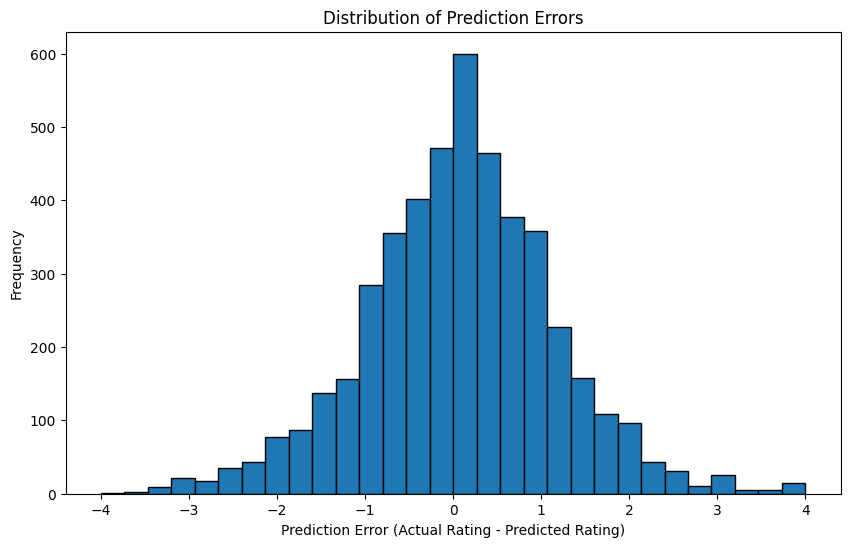

In [77]:
# Calculate errors
errors = actual_ratings_flat - predicted_ratings_flat

# Plotting the distribution of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Actual Rating - Predicted Rating)")
plt.ylabel("Frequency")
plt.show()

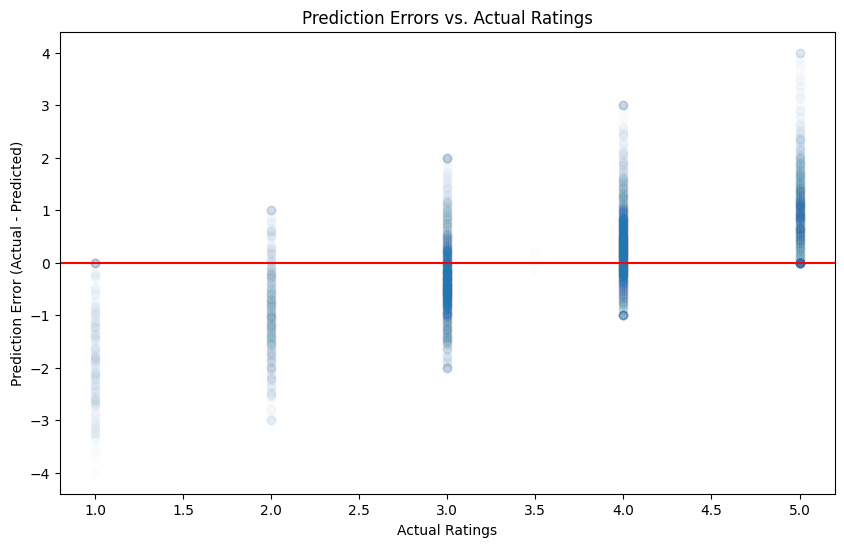

In [80]:
# Scatter plot of errors against actual ratings
plt.figure(figsize=(10, 6))
plt.scatter(actual_ratings_flat, errors, alpha=0.01)
plt.title("Prediction Errors vs. Actual Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.axhline(y=0, color='r', linestyle='-')  # Line at error = 0
plt.show()
